In [1]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16
np.random.seed(0)
tf.compat.v1.random.set_random_seed(0)

In [2]:
fakepath = '/kaggle/input/model-training-dataset/fake/'
originalpath = "/kaggle/input/model-training-dataset/original/"
fake = []
original = []

In [3]:
for name in tqdm(os.listdir(fakepath)):
    for frame in os.listdir(fakepath + name):
        fake.append(fakepath + name + '/' + frame)

100%|██████████| 1481/1481 [00:01<00:00, 772.38it/s]


In [4]:
for name in tqdm(os.listdir(originalpath)):
    for frame in os.listdir(originalpath + name):
        original.append(originalpath + name + '/' + frame)

100%|██████████| 362/362 [00:00<00:00, 670.19it/s]


In [5]:
y = np.ones(len(original))
x = np.zeros(len(fake))
label = np.concatenate([y, x])
names_list = original + fake
new_data, new_label = shuffle(names_list, label,  random_state = 0)
train, test, y_train, y_test = new_data[:-100], new_data[-100:], new_label[:-100], new_label[-100:]

In [6]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) 
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_saturation(img, 1, 3)
    img = tf.image.random_brightness(img, 0.3)
    img = tf.image.resize(img, [75, 75])
    return img

def get_label(file_path):
    cat = tf.strings.split(file_path, '/')[4]
    if cat == b'fake':
        return 1
    return 0

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [7]:
num_threads, num_epochs, train_len = 5, 3000, len(train) 
train_ds = tf.data.Dataset.from_tensor_slices(train)
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [8]:
train_ds = train_ds.shuffle(train_len)
train_ds = train_ds.batch(64)
train_ds = train_ds.prefetch(1)

In [9]:
from tensorflow.keras.applications import ResNet152V2
model = ResNet152V2(
    include_top=False,
    weights="imagenet",
    input_shape=(75, 75, 3))

234553344/234545216 [==============================] - 3s 0us/step


In [10]:
for layer in model.layers[:42]:
    layer.trainable = False

In [11]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-1,
    decay_steps=10,
    decay_rate=0.9)
opt = tf.keras.optimizers.Adam(
    learning_rate= lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)
tp = tf.keras.metrics.TruePositives(thresholds=None, name=None, dtype=None)
tn = tf.keras.metrics.TrueNegatives(thresholds=None, name=None, dtype=None)
fp = tf.keras.metrics.FalsePositives(thresholds=None, name=None, dtype=None)
fn = tf.keras.metrics.FalseNegatives(thresholds=None, name=None, dtype=None)

In [12]:
classifier = Sequential()
classifier.add(model)
classifier.add(Flatten())
classifier.add(Dense(1024, activation='relu'))
classifier.add(Dense(1, activation = 'sigmoid'))
classifier.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy', tp,tn,fp,fn])

In [13]:
history = classifier.fit(train_ds, epochs = 20, shuffle=True, batch_size=64)

Epoch 1/20
944/944 [==============================] - 154s 163ms/step - loss: 10.2556 - accuracy: 0.7818 - true_positives: 47214.0000 - true_negatives: 8.0000 - false_positives: 13141.0000 - false_negatives: 42.0000
Epoch 2/20
944/944 [==============================] - 154s 164ms/step - loss: 0.5240 - accuracy: 0.7823 - true_positives: 47256.0000 - true_negatives: 0.0000e+00 - false_positives: 13149.0000 - false_negatives: 0.0000e+00
Epoch 3/20
944/944 [==============================] - 155s 164ms/step - loss: 0.5240 - accuracy: 0.7823 - true_positives: 47256.0000 - true_negatives: 0.0000e+00 - false_positives: 13149.0000 - false_negatives: 0.0000e+00
Epoch 4/20
944/944 [==============================] - 155s 164ms/step - loss: 0.5240 - accuracy: 0.7823 - true_positives: 47256.0000 - true_negatives: 0.0000e+00 - false_positives: 13149.0000 - false_negatives: 0.0000e+00
Epoch 5/20
944/944 [==============================] - 154s 163ms/step - loss: 0.5240 - accuracy: 0.7823 - true_positiv

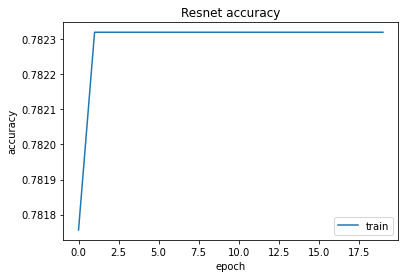

In [15]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('Resnet accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()


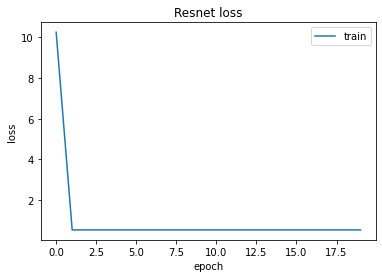

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Resnet loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()